# NLP Sentiment Analysis: Apple and Google Products' Tweets

## 1 Introduction

This notebook presents a complete workflow for building and evaluating machine learning models to classify the sentiment of tweets related to Apple and Google products. The process includes data loading, cleaning, preprocessing, feature engineering, model training, and performance evaluation. The objective is to accurately determine whether a tweet expresses a positive, negative, or neutral sentiment towards these technology brands, and to recommend the most effective model for deployment.

## 2 Data Preparation

### 2.1 Data Loading

- Import all required libraries for data analysis, NLP, and modeling

In [1]:
# Import necessary libraries
import pandas as pd  
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer 
from nltk import pos_tag  
import string  
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.neural_network import MLPClassifier  
from sklearn.pipeline import Pipeline  
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.preprocessing import FunctionTransformer  
import re  

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

- Load the `tweet_product_company.csv` dataset

In [2]:
# Load the dataset from CSV file
df = pd.read_csv('/home/mwakad/Desktop/projects/group2/NLP-models-for-twitter-sentiment-analysis--google-and-apple-products-/data/tweet_product_company.csv', encoding='Latin-1')  # Read CSV file with correct encoding

- Inspect fist five columns

In [3]:
# Print first 5 rows
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


- Inspect columns 

In [4]:
# Print column attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


### 2.2 Data Cleaning

- Check duplicates

In [5]:
df.duplicated().sum()

np.int64(22)

- Drop duplicates

In [6]:
df = df.drop_duplicates()

In [7]:
# Confirm no duplicate entries
df.duplicated().sum()

np.int64(0)

- Rename Columns for Clarity

In [8]:
# Rename columns 
df = df.rename(columns={
    'tweet_text': 'tweet',  # Rename tweet text column
    'emotion_in_tweet_is_directed_at': 'product',  # Rename product column
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'  # Rename sentiment column
})

In [9]:
# Recheck columns' attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9071 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9070 non-null   object
 1   product    3282 non-null   object
 2   sentiment  9071 non-null   object
dtypes: object(3)
memory usage: 283.5+ KB


- It is evident the `products` column has many missing values.
- Inspect unique values for the `products` column

In [10]:
df['product'].value_counts()

product
iPad                               945
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: count, dtype: int64

Define a function **_categorize_product_** that takes the parameter `tweet` from **_df_**.
- Check if the input `tweet` is null or missing (If **_true_**; return **unknown**).
- If **_false_**; convert the string for each entry for the column `tweet` to lowercase to ensure case-insensitive matching.
- If the string for the column `tweet` contains the words: **_'iphone', 'ipad', or 'apple'_**; return **Apple**.
- If the string for the column `tweet` contains the words: **_'google', or 'android'_**; return **Google**.
- If none of these conditions are met return **unknown**.

In [11]:
# Define a function to categorize products
def categorize_product(tweet):
    if pd.isnull(tweet):
        return 'unknown'
    tweet = tweet.lower()
    if 'iphone' in tweet or 'ipad' in tweet or 'apple' in tweet:
        return 'Apple'
    elif 'google' in tweet or 'android' in tweet:
        return 'Google'
    else:
        return 'unknown'

# Apply the function to the 'tweet' column and fill the 'product' column
df['product'] = df['tweet'].apply(categorize_product)

# Verify the changes
df['product'].value_counts()


product
Apple      5520
Google     2766
unknown     785
Name: count, dtype: int64

- Handle Missing Values

In [12]:
# Srop entries with the value `unknown' for the `product` column
df = df[df['product'] != 'unknown']

In [13]:
# Drop rows with missing values in 'tweet' or 'sentiment' columns
df = df.dropna(subset=['tweet', 'sentiment']) 

In [14]:
# Remove rows where sentiment is 'I can't tell'
df = df[df['sentiment'] != "I can't tell"] 

In [15]:
# Reset index after dropping rows
df = df.reset_index(drop=True)  

In [16]:
# Re-inspect column attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      8136 non-null   object
 1   product    8136 non-null   object
 2   sentiment  8136 non-null   object
dtypes: object(3)
memory usage: 190.8+ KB


In [17]:
# Rename Sentiments
df.loc[:, 'sentiment'] = df['sentiment'].replace({
    'No emotion toward brand or product': 'Neutral',
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative'})

In [18]:
# Verify changes
df['sentiment'].value_counts()

sentiment
Neutral     4636
Positive    2932
Negative     568
Name: count, dtype: int64

## 3 Data Preprocessing  

### 3.1 Define helper functions for preprocessing

- Text cleaning

In [19]:
# Define function to remove URLs, mentions, hashtags, punctuation, and lowercase
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

- Stopword removal

In [20]:
# Define function to remove stopwords from text
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    pronouns = {'i', 'me', 'my', 'mine', 'myself', 'you', 'your', 'yours', 'yourself',
                'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
                'it', 'its', 'itself', 'we', 'us', 'our', 'ours', 'ourselves',
                'they', 'them', 'their', 'theirs', 'themselves'}
    stop_words += pronouns
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

- Lemmatization

In [21]:
# Define function to lemmatize each word in the text
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

- Stemming

In [22]:
# Define function to Stem each word in the text
def stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in tokens])

- POS Tagging

In [23]:
# Define function to lemmatize using POS tagging
def pos_lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return 'a'
        elif tag.startswith('V'):
            return 'v'
        elif tag.startswith('N'):
            return 'n'
        elif tag.startswith('R'):
            return 'r'
        else:
            return 'n'
    return ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags])

In [24]:
# Define function to stem using POS tagging
def pos_stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return ' '.join([stemmer.stem(word) for word, _ in pos_tags])

- Tokenization

In [25]:
# Define function to tokenize using TweetTokenizer
def tweet_tokenize_text(text):
    tokenizer = TweetTokenizer()
    return ' '.join(tokenizer.tokenize(text))

In [26]:
# Define function to tokenize using word_tokenize
def word_tokenize_text(text):
    return word_tokenize(text)

### 3.2 Extrapolatory Data Analysis

In [27]:
# create a copy of df
df_clean = df.copy()

In [28]:
df_clean['clean_tweet'] = df_clean['tweet'].apply(clean_text)
df_clean.head()

,tweet,product,sentiment,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative,i have a g iphone after hrs tweeting at it ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive,know about awesome ipadiphone app that youl...
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive,can not wait for also they should sale them...
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative,i hope this years festival isnt as crashy as ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google tim ...


In [29]:
df_clean['stopwords_removed'] = df_clean['clean_tweet'].apply(remove_stopwords)
df_clean.head()

,tweet,product,sentiment,clean_tweet,stopwords_removed
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative,i have a g iphone after hrs tweeting at it ...,g iphone hrs tweeting dead need upgrade plugin...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive,know about awesome ipadiphone app that youl...,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive,can not wait for also they should sale them...,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative,i hope this years festival isnt as crashy as ...,hope years festival isnt crashy years iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google tim ...,great stuff fri marissa mayer google tim oreil...


In [30]:
df_clean['tokenized_tweet'] = df_clean['stopwords_removed'].apply(word_tokenize_text)
df_clean.head()

,tweet,product,sentiment,clean_tweet,stopwords_removed,tokenized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative,i have a g iphone after hrs tweeting at it ...,g iphone hrs tweeting dead need upgrade plugin...,"[g, iphone, hrs, tweeting, dead, need, upgrade..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive,know about awesome ipadiphone app that youl...,know awesome ipadiphone app youll likely appre...,"[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive,can not wait for also they should sale them...,wait also sale,"[wait, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative,i hope this years festival isnt as crashy as ...,hope years festival isnt crashy years iphone app,"[hope, years, festival, isnt, crashy, years, i..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,great stuff on fri marissa mayer google tim ...,great stuff fri marissa mayer google tim oreil...,"[great, stuff, fri, marissa, mayer, google, ti..."


In [31]:
df_clean[['product', 'sentiment', 'tokenized_tweet']].head()

,product,sentiment,tokenized_tweet
0,Apple,Negative,"[g, iphone, hrs, tweeting, dead, need, upgrade..."
1,Apple,Positive,"[know, awesome, ipadiphone, app, youll, likely..."
2,Apple,Positive,"[wait, also, sale]"
3,Apple,Negative,"[hope, years, festival, isnt, crashy, years, i..."
4,Google,Positive,"[great, stuff, fri, marissa, mayer, google, ti..."


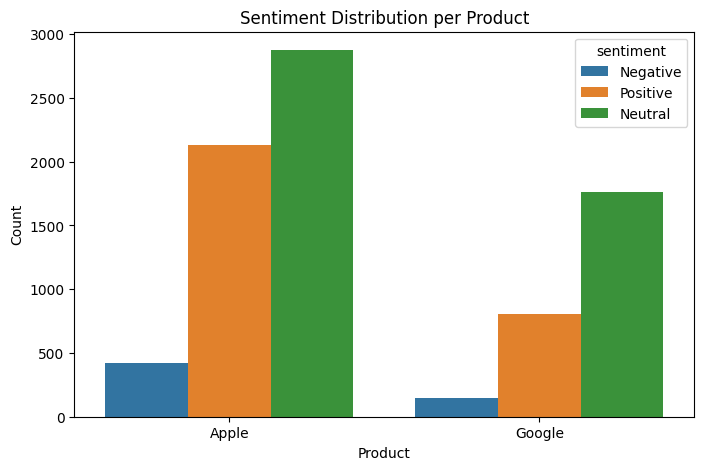

In [32]:
# Count plot of product vs sentiment
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clean, x='product', hue='sentiment')
plt.title('Sentiment Distribution per Product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.show()

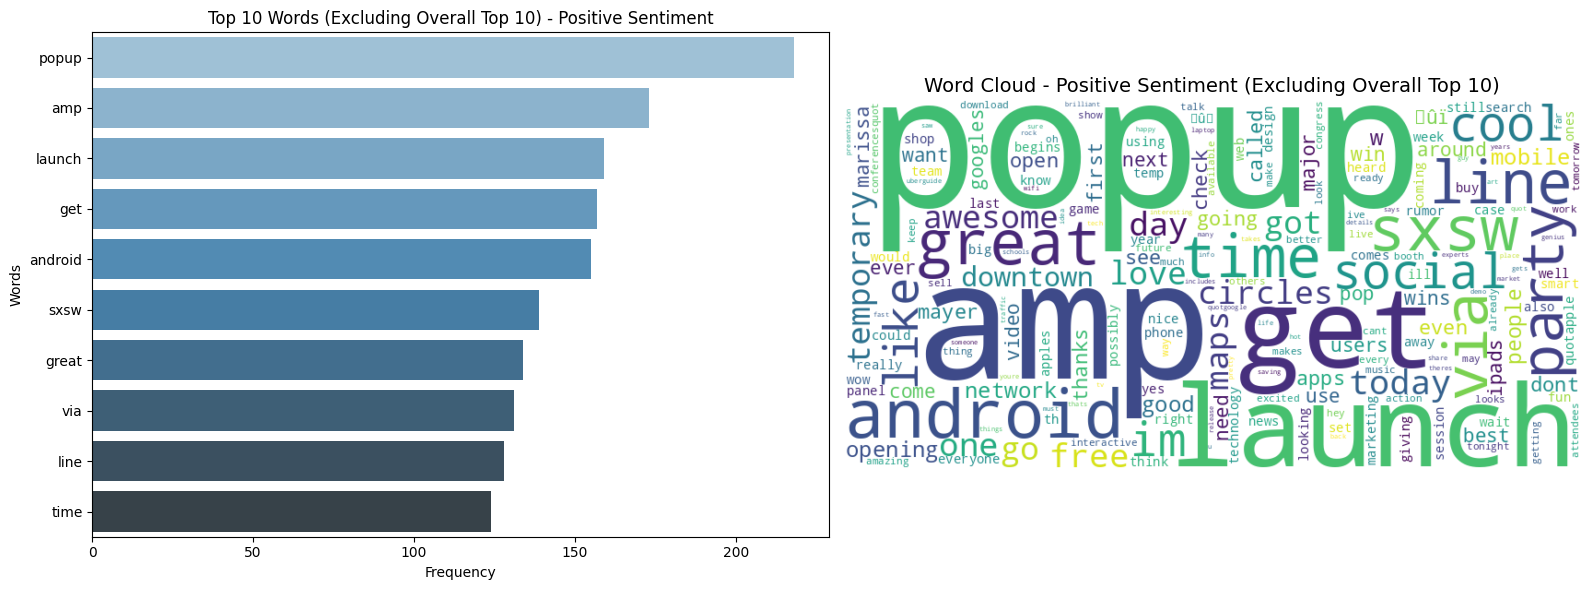

In [44]:
# Filter tokens for positive sentiment
top_10_words_to_exclude = positive_freq.most_common(10)
top_10_word_set = {word for word, count in top_10_words_to_exclude}

# Filter frequencies: exclude the top 10 most common words 
filtered_positive_freq = Counter()
for word, count in positive_freq.items():
    if word not in top_10_word_set:
        filtered_positive_freq[word] = count

top_words_for_barplot = filtered_positive_freq.most_common(10)
words_barplot, counts_barplot = zip(*top_words_for_barplot)

# Set up 1x2 plt.subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot on LHS (uses filtered data)
if words_barplot: # Check if there are words to plot after filtering
    sns.barplot(ax=axes[0], x=list(counts_barplot), y=list(words_barplot), palette='Blues_d', legend=False)
    axes[0].set_title("Top 10 Words (Excluding Overall Top 10) - Positive Sentiment")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Words")
else:
    axes[0].set_title("No words to plot for barplot after exclusion", fontsize=12)
    axes[0].axis('off')


# Word cloud on RHS (uses filtered data)
if filtered_positive_freq: # Check if there are words left for the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_positive_freq)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].set_title("Word Cloud - Positive Sentiment (Excluding Overall Top 10)", fontsize=14)
    axes[1].axis('off')
else:
    axes[1].set_title("Word Cloud (No words after exclusion)", fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

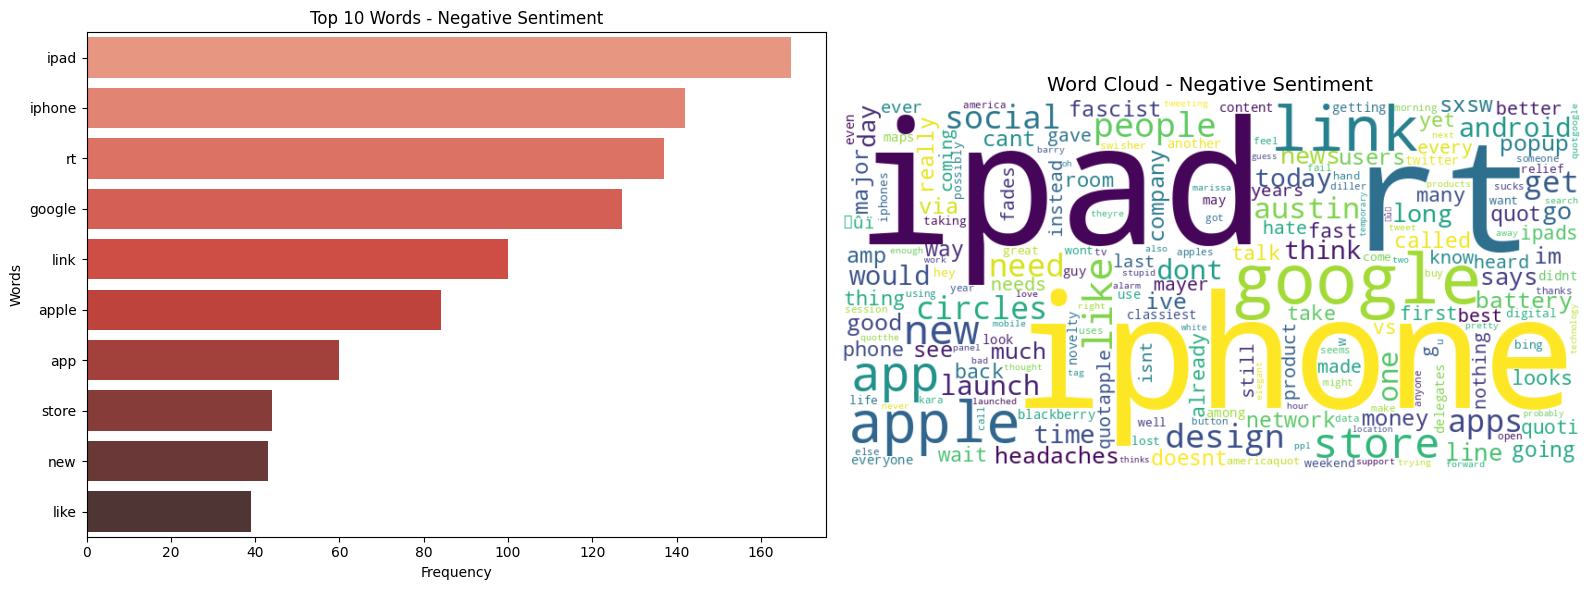

In [34]:
# Filter tokens for negative sentiment
negative_tokens = df_clean[df_clean['sentiment'] == 'Negative']['tokenized_tweet'].sum()
negative_freq = Counter(negative_tokens) # This is the full frequency for all negative tokens

# Plot most common words excluding top ten most frequent
top_10_words_to_exclude = negative_freq.most_common(10) # Get top 10 from overall negative_freq
top_10_word_set = {word for word, count in top_10_words_to_exclude}

# Filter frequencies: exclude the top 10 most common words
filtered_negative_freq = Counter()
for word, count in negative_freq.items():
    if word not in top_10_word_set:
        filtered_negative_freq[word] = count

top_words_for_barplot = filtered_negative_freq.most_common(10) # Get top 10 from the filtered list
# Check if top_words_for_barplot is not empty before unpacking
if top_words_for_barplot:
    words_barplot, counts_barplot = zip(*top_words_for_barplot)
else:
    words_barplot, counts_barplot = [], [] # Assign empty lists if no words

# Set up 1x2 plt.subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot
if words_barplot: # Check if there are words to plot after filtering
    sns.barplot(ax=axes[0], x=list(counts_barplot), y=list(words_barplot), palette='Reds_d', legend=False)
    axes[0].set_title("Top 10 Words (Excluding Overall Top 10) - Negative Sentiment")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Words")
else:
    axes[0].set_title("No words to plot for barplot after exclusion", fontsize=12)
    axes[0].axis('off')


# Word cloud plot
if filtered_negative_freq: # Check if there are words left for the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_negative_freq)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].set_title("Word Cloud - Negative Sentiment (Excluding Overall Top 10)", fontsize=14)
    axes[1].axis('off')
else:
    axes[1].set_title("Word Cloud (No words after exclusion)", fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

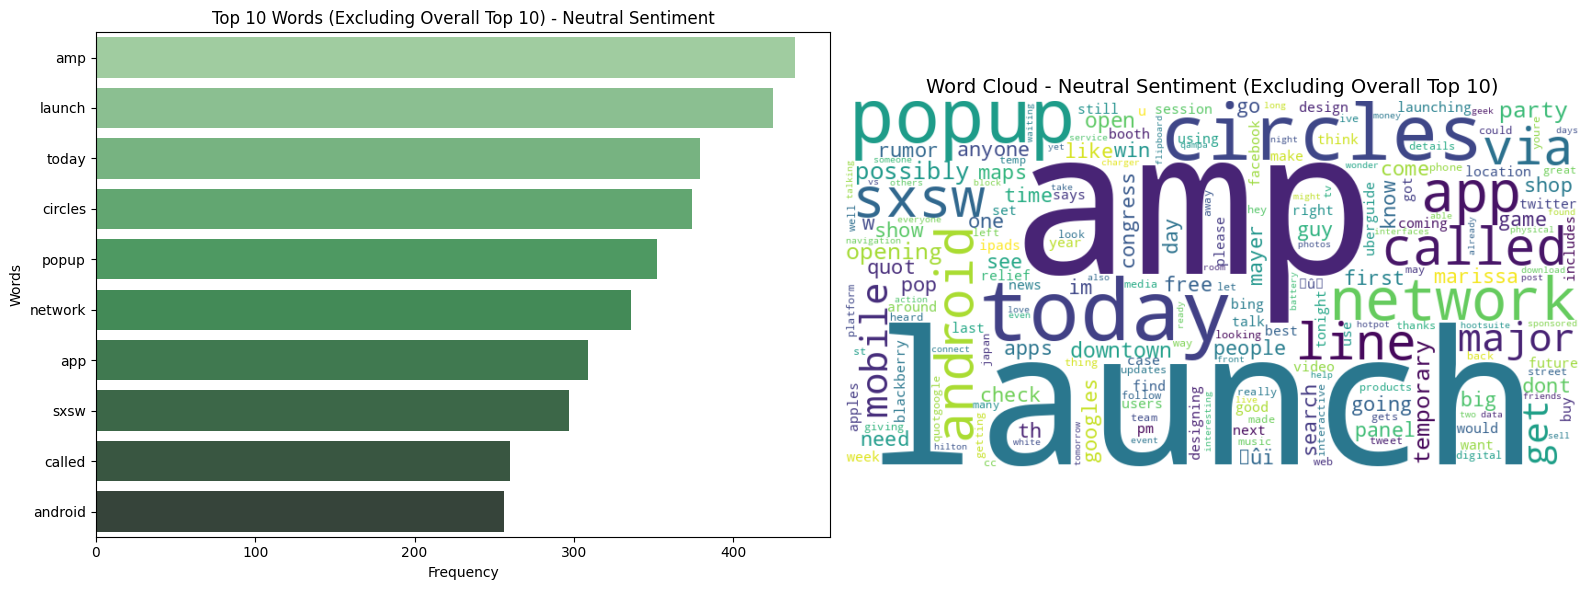

In [43]:
# Filter tokens for neutral sentiment
neutral_tokens = df_clean[df_clean['sentiment'] == 'Neutral']['tokenized_tweet'].sum()
neutral_freq = Counter(neutral_tokens) # This is the full frequency for all neutral tokens

# Plot most common words excluding top ten most frequent
top_10_words_to_exclude = neutral_freq.most_common(10) # Get top 10 from overall neutral_freq
top_10_word_set = {word for word, count in top_10_words_to_exclude}

# Filter frequencies: exclude the top 10 most common words
filtered_neutral_freq = Counter()
for word, count in neutral_freq.items():
    if word not in top_10_word_set:
        filtered_neutral_freq[word] = count

top_words_for_barplot = filtered_neutral_freq.most_common(10) # Get top 10 from the filtered list
# Check if top_words_for_barplot is not empty before unpacking
if top_words_for_barplot:
    words_barplot, counts_barplot = zip(*top_words_for_barplot)
else:
    words_barplot, counts_barplot = [], [] # Assign empty lists if no words

# Set up 1x2 plt.subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Barplot
if words_barplot: # Check if there are words to plot after filtering
    sns.barplot(ax=axes[0], x=list(counts_barplot), y=list(words_barplot), palette='Greens_d', legend=False)
    axes[0].set_title("Top 10 Words (Excluding Overall Top 10) - Neutral Sentiment")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Words")
else:
    axes[0].set_title("No words to plot for barplot after exclusion", fontsize=12)
    axes[0].axis('off')


# Word cloud plot
if filtered_neutral_freq: # Check if there are words left for the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_neutral_freq)
    axes[1].imshow(wordcloud, interpolation='bilinear')
    axes[1].set_title("Word Cloud - Neutral Sentiment (Excluding Overall Top 10)", fontsize=14)
    axes[1].axis('off')
else:
    axes[1].set_title("Word Cloud (No words after exclusion)", fontsize=14)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4 Modelling

### 4.1 Define Helper Functions for Vectorization

- Define function to perform **_Bag-of-Words_** vectorization

In [36]:
# Define function to perform BoW vectorization
def bow_vectorize_text(text_data, max_features=10, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(max_features=max_features, stopwords=stop_words)
    bow_matrix = vectorizer.fit_transform(text_data)
    return bow_matrix, BoW_vectorizer

- Define funtion to perform **_Term Frequency-Inverse Document Frequency_** vectorization

In [37]:
# Define function to perform TF-IDF vectorization
def tfidf_vectorize_text(text_data, max_features=10, ngram_range=(1, 1)):
    vectorizer = TfidfVectorizer(max_features=max_features, stopwords=stop_words)
    tfidf_matrix = vectorizer.fit_transform(text_data)
    return tfidf_matrix, TFIDF_vectorizer

### 4.2 Train-Test Split

### 4.3 Train-Validation Split